<a href="https://colab.research.google.com/github/hila-chefer/Transformer-MM-Explainability/blob/main/CLIP_explainability.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Activation Visualization
Code adapted from: https://github.com/hila-chefer/Transformer-MM-Explainability/blob/main/CLIP_explainability.ipynb

In [1]:
import os
os.chdir(f'./SKI_Models')

In [2]:
import cv2
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import torch
from datasets.build import build_dataloader_noddp
from utils.logger import create_logger
from apex import amp
from trainers import vificlip, Froster_ViFiCLIP_net

/home/asinha13/miniconda3/envs/vclip/lib/python3.7/site-packages/mmcv/__init__.py:21: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  'On January 1, 2023, MMCV will release v2.0.0, in which it will remove '


In [114]:
if torch.cuda.is_available():
    torch.cuda.set_device(0)
else:
    print("No GPU")

In [115]:
from utils.config import get_config, _C

config = _C
config.merge_from_file('./path/to/config/novel_eval_48_12.yaml')

logger = create_logger(output_dir=config.OUTPUT, dist_rank=0, name="Test")

train_data, test_data, train_loader, test_loader = build_dataloader_noddp(logger='', config=config)
class_names = [class_name for i, class_name in test_data.classes]

In [116]:
ann_file = 'path/to/annotation_file/zsl_48-12_ntu60_novel_data.csv'
ann_df = pd.read_csv(ann_file, header=None)
ann_df.head()

In [119]:
## path to NTU video
video_path1 = '/path/to/video1.avi'
video_path2 = '/path/to/video2.avi'


In [120]:
def get_row_id(df, val):
    return df[df[0] == val].index[0]

In [121]:
video_path1_row_id = get_row_id(ann_df, video_path1)
video_path2_row_id = get_row_id(ann_df, video_path2)

In [122]:
video_path1_row_id, video_path2_row_id

(6, 15)

In [125]:
def load_video(video_path, num_frames=45):
    cap = cv2.VideoCapture(video_path)
    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)
    cap.release()
    frames = np.array(frames)
    print(len(frames))
    if len(frames) < num_frames:
        frames = np.concatenate([frames, np.zeros((num_frames-len(frames), frames.shape[1], frames.shape[2], frames.shape[3]), dtype=frames.dtype)], axis=0)
    return frames[:num_frames]

In [126]:
vid1 = load_video(video_path1)
vid2 = load_video(video_path2)

99
84


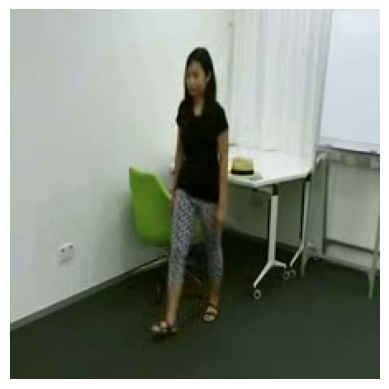

In [127]:
plt.imshow(vid1[31])
plt.axis('off')
plt.show()

# **Visualization**

In [132]:
import torch
import clip as clip
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
from captum.attr import visualization

In [133]:
#@title Control context expansion (number of attention layers to consider)
#@title Number of layers for image Transformer
start_layer =  -1#@param {type:"number"}

#@title Number of layers for text Transformer
start_layer_text =  -1#@param {type:"number"}

In [138]:
model = vificlip.returnCLIP(config,
                            logger=logger,
                            class_names=class_names,)
                            # args=args) # pass args to indicate that we want to load the hyperformer model

model = model.cuda()

model = amp.initialize(models=model, optimizers=None, opt_level=config.TRAIN.OPT_LEVEL)
model = model.eval()

[2024-04-17 11:37:00 Test](vificlip.py 202): INFO Loading CLIP (backbone: ViT-B/16)
[2024-04-17 11:37:02 Test](vificlip.py 205): INFO Building ViFi-CLIP CLIP
[2024-04-17 11:37:02 Test](vificlip.py 222): INFO Turning on gradients for COMPLETE ViFi-CLIP model
[2024-04-17 11:37:02 Test](vificlip.py 245): INFO Parameters to be updated: {'image_encoder.transformer.resblocks.7.ln_1.weight', 'image_encoder.transformer.resblocks.6.attn.in_proj_weight', 'image_encoder.transformer.resblocks.7.ln_2.bias', 'text_encoder.transformer.resblocks.6.mlp.c_proj.weight', 'text_encoder.transformer.resblocks.1.ln_2.bias', 'image_encoder.transformer.resblocks.11.attn.in_proj_bias', 'text_encoder.transformer.resblocks.0.attn.out_proj.weight', 'text_encoder.transformer.resblocks.8.mlp.c_fc.weight', 'image_encoder.transformer.resblocks.1.attn.in_proj_weight', 'image_encoder.transformer.resblocks.2.mlp.c_fc.weight', 'text_encoder.transformer.resblocks.8.mlp.c_fc.bias', 'text_encoder.transformer.resblocks.2.mlp.c

In [139]:
base_model = vificlip.returnCLIP(config,
                            logger=logger,
                            class_names=class_names,)

base_model = base_model.cuda()

base_model = amp.initialize(models=base_model, optimizers=None, opt_level=config.TRAIN.OPT_LEVEL)
base_model = base_model.eval()

[2024-04-17 11:37:09 Test](vificlip.py 202): INFO Loading CLIP (backbone: ViT-B/16)
[2024-04-17 11:37:10 Test](vificlip.py 205): INFO Building ViFi-CLIP CLIP
[2024-04-17 11:37:10 Test](vificlip.py 222): INFO Turning on gradients for COMPLETE ViFi-CLIP model
[2024-04-17 11:37:10 Test](vificlip.py 245): INFO Parameters to be updated: {'image_encoder.transformer.resblocks.7.ln_1.weight', 'image_encoder.transformer.resblocks.6.attn.in_proj_weight', 'image_encoder.transformer.resblocks.7.ln_2.bias', 'text_encoder.transformer.resblocks.6.mlp.c_proj.weight', 'text_encoder.transformer.resblocks.1.ln_2.bias', 'image_encoder.transformer.resblocks.11.attn.in_proj_bias', 'text_encoder.transformer.resblocks.0.attn.out_proj.weight', 'text_encoder.transformer.resblocks.8.mlp.c_fc.weight', 'image_encoder.transformer.resblocks.1.attn.in_proj_weight', 'image_encoder.transformer.resblocks.2.mlp.c_fc.weight', 'text_encoder.transformer.resblocks.8.mlp.c_fc.bias', 'text_encoder.transformer.resblocks.2.mlp.c

In [140]:
p1_img_txt_path = '/path/to/model_checkpoint/'

checkpoint = torch.load(p1_img_txt_path, map_location='cpu')
load_state_dict = checkpoint['model']

# now remove the unwanted keys:
if "module.prompt_learner.token_prefix" in load_state_dict:
    del load_state_dict["module.prompt_learner.token_prefix"]

if "module.prompt_learner.token_suffix" in load_state_dict:
    del load_state_dict["module.prompt_learner.token_suffix"]

if "module.prompt_learner.complete_text_embeddings" in load_state_dict:
    del load_state_dict["module.prompt_learner.complete_text_embeddings"]

new_state_dict = {}
for key in load_state_dict:
    new_key = key.replace('module.', '')
    new_state_dict[new_key] = load_state_dict[key]

mk, uk = base_model.load_state_dict(new_state_dict, strict=False)
mk, uk

(['prompt_learner.complete_text_embeddings'], [])

In [142]:
image_list = []

for batch in test_loader:
    images = batch['imgs']
    image_list.extend(images)

print(len(image_list))


11312


In [143]:
# vid_ids = [58, 68]
vid_ids = [video_path1_row_id, video_path2_row_id]

In [145]:
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

In [146]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# img = [image_list[i].cuda() for i in vid_ids]
img = image_list[video_path1_row_id].cuda()
# texts = ['sneeze/cough', 'sneeze/cough']
# texts = ["a man with eyeglasses"]
# text = clip.tokenize(texts).to(device)
stacked_images = torch.stack([image_list[i].cuda() for i in vid_ids])
stacked_images.shape

torch.Size([2, 16, 3, 224, 224])

In [149]:
def interpret(image, texts, model, device, start_layer=-1, start_layer_text=-1):
    batch_size = image.shape[0]
    images = image#.repeat(batch_size, 1, 1, 1)
    # logits_per_image, logits_per_text = model(images, texts)
    logits_per_image, logits_per_text, _ = model(images)
    probs = logits_per_image.softmax(dim=-1).detach().cpu().numpy()
    index = [i for i in range(batch_size)]
    one_hot = np.zeros((logits_per_image.shape[0], logits_per_image.shape[1]), dtype=np.float32)
    one_hot[torch.arange(logits_per_image.shape[0]), index] = 1
    one_hot = torch.from_numpy(one_hot).requires_grad_(True)
    one_hot = torch.sum(one_hot.cuda() * logits_per_image)
    model.zero_grad()

    image_attn_blocks = list(dict(model.image_encoder.transformer.resblocks.named_children()).values())

    if start_layer == -1: 
      # calculate index of last layer 
      start_layer = len(image_attn_blocks) - 1
    
    num_tokens = image_attn_blocks[0].attn_probs.shape[-1]
    R = torch.eye(num_tokens, num_tokens, dtype=image_attn_blocks[0].attn_probs.dtype).to(device)
    R = R.unsqueeze(0).expand(batch_size, num_tokens, num_tokens)
    for i, blk in enumerate(image_attn_blocks):
        if i < start_layer:
          continue
        grad = torch.autograd.grad(one_hot, [blk.attn_probs], retain_graph=True, allow_unused=True)[0].detach()
        cam = blk.attn_probs.detach()
        cam = cam.reshape(-1, cam.shape[-1], cam.shape[-1])
        grad = grad.reshape(-1, grad.shape[-1], grad.shape[-1])
        cam = grad * cam
        cam = cam.reshape(batch_size, -1, cam.shape[-1], cam.shape[-1])
        cam = cam.clamp(min=0).mean(dim=1)
        R = R + torch.bmm(cam, R)
    image_relevance = R[:, 0, 1:]
    
    text_attn_blocks = list(dict(model.text_encoder.transformer.resblocks.named_children()).values())

    R_text = torch.eye(num_tokens, num_tokens, dtype=text_attn_blocks[0].attn_probs.dtype).to(device)
    R_text = R_text.unsqueeze(0).expand(batch_size, num_tokens, num_tokens)
    # for i, blk in enumerate(text_attn_blocks):
    #     print(i, blk.attn_probs)
    #     print(one_hot)
    #     if i < start_layer_text:
    #       continue
    #     grad = torch.autograd.grad(one_hot, [blk.attn_probs], retain_graph=True, allow_unused=True)[0].detach()
    #     cam = blk.attn_probs.detach()
    #     cam = cam.reshape(-1, cam.shape[-1], cam.shape[-1])
    #     grad = grad.reshape(-1, grad.shape[-1], grad.shape[-1])
    #     cam = grad * cam
    #     cam = cam.reshape(batch_size, -1, cam.shape[-1], cam.shape[-1])
    #     cam = cam.clamp(min=0).mean(dim=1)
    #     R_text = R_text + torch.bmm(cam, R_text)
    text_relevance = R_text
   
    return text_relevance, image_relevance

# R_text, R_image = interpret(model=model, image=stacked_images, texts='text', device=device)    

In [150]:
def show_image_relevance(image_relevance, image, orig_image, frame=8):
    # create heatmap from mask on image
    def show_cam_on_image(img, mask):
        heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
        heatmap = np.float32(heatmap) / 255
        cam = heatmap + np.float32(img)
        cam = cam / np.max(cam)
        return cam

    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(orig_image);
    axs[0].axis('off');

    dim = int(image_relevance.numel() ** 0.5)
    image_relevance = image_relevance.reshape(1, 1, dim, dim)
    image_relevance = torch.nn.functional.interpolate(image_relevance, size=224, mode='bilinear')
    image_relevance = image_relevance.reshape(224, 224).cuda().data.cpu().numpy()
    image_relevance = (image_relevance - image_relevance.min()) / (image_relevance.max() - image_relevance.min())

    image1 = image[frame]
    image1 = image1.permute(1, 2, 0).data.cpu().numpy()
    image1 = (image1 - image1.min()) / (image1.max() - image1.min())


    vis = show_cam_on_image(image1, image_relevance)
    vis = np.uint8(255 * vis)
    vis = cv2.cvtColor(np.array(vis), cv2.COLOR_RGB2BGR)
    axs[1].imshow(vis);
    axs[1].axis('off');


In [151]:
text = ['walking towards each other', 'walking towards each other']

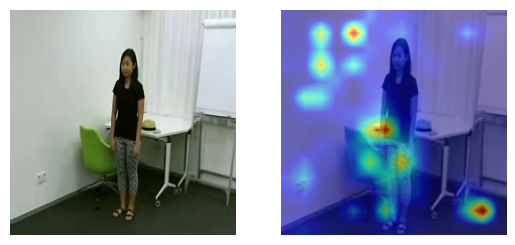

In [173]:
start_layer = -1
R_text, R_image = interpret(model=base_model, image=stacked_images, texts=text, start_layer = start_layer, device=device)    

show_image_relevance(R_image[0], img, orig_image=vid1[12], frame=1)
plt.show()

Comment: The visualizations tend to emphasize static elements of the background due to absence of registers during training, as discussed in [1]. These high background values are disregarded in our analysis. <br>
[1] Darcet, Timothée, et al. "Vision transformers need registers." arXiv preprint arXiv:2309.16588 (2023).